In [3]:
from loader.mnist import MNIST, MNIST_NORMALIZATION
from loader.emnist import EMNIST
from loader.fmnist import FashionMNIST
from core.cnn import simple_cnn
from core.maha import maha_distance
from torchvision import datasets,transforms
import torch
import numpy as np
from core.score import plot, plot_confidence_hist, histogram_binning_calibrator
import matplotlib.pyplot as plt

In [4]:
tf = transforms.Compose([
            transforms.ToTensor(),
            MNIST_NORMALIZATION,
        ])
train_data = MNIST('./dataset/',download=True,transform=tf)
test_id = MNIST('./dataset/', download=True,transform=tf,train=False)
val_id = MNIST('./dataset/', download=True,transform=tf,train=True,val=True)
test_near_ood = EMNIST('./dataset/',download=True,transform=tf,train=False,split='letters')
test_far_ood = FashionMNIST('./dataset/',download=True,transform=tf,train=False)

train_loader = torch.utils.data.DataLoader(train_data,batch_size = 128,shuffle=True)
val_id_loader = torch.utils.data.DataLoader(val_id,batch_size = 128,shuffle=False)
test_id_loader = torch.utils.data.DataLoader(test_id,batch_size = 128,shuffle=False)
test_near_ood_loader = torch.utils.data.DataLoader(test_near_ood,batch_size = 128,shuffle=False)
test_far_ood_loader = torch.utils.data.DataLoader(test_far_ood,batch_size = 128,shuffle=False)

In [5]:
model = simple_cnn(y_dim = 10,h_dims=[128,32]).to('cuda:0')
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-4)


### Training

In [6]:
for e in range(5):
    for image,label in train_loader:
        out = model(image.to('cuda'))
        # print(out.shape,label)
        loss = criterion(out,label.to('cuda'))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss)

tensor(0.1699, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0909, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1994, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0889, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0451, device='cuda:0', grad_fn=<NllLossBackward0>)


### Test Accuracy

In [16]:
model.eval()
y_true = []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_id_loader:
        out = model(image.to('cuda'))
        _,pred_logit = torch.max(out,dim=-1)
        y_true += (label==pred_logit.cpu()).numpy().tolist()
        num_acc += (label == pred_logit.cpu()).sum().item()
        total += label.shape[0]
print("Accuracy:{}".format(num_acc/total))

Accuracy:0.9854


### Uncertainty

In [8]:
from core.gmm import GaussianMixture
gmm = GaussianMixture(10,32)

In [9]:
ftrain = []
with torch.no_grad():
    for image,label in train_loader:
        feature = model.net(image.to('cuda'))
        ftrain += feature.cpu().numpy().tolist()
ftrain = torch.tensor(ftrain)
gmm.fit(ftrain)

In [10]:
scale = 1e6

id_score = []
with torch.no_grad():
    for image,label in test_id_loader:
        feature = model.net(image.to('cuda')).cpu()
        q = gmm.q(feature)
        q = -q/scale
        id_score += q.numpy().tolist()
id_score = np.asarray(id_score)
print(id_score.mean())


near_ood_score = []
with torch.no_grad():
    for image,label in test_near_ood_loader:
        feature = model.net(image.to('cuda')).cpu()
        q = gmm.q(feature)
        q = -q/scale
        near_ood_score += q.numpy().tolist()
near_ood_score = np.asarray(near_ood_score)
print(near_ood_score.mean())


far_ood_score = []
with torch.no_grad():
    for image,label in test_far_ood_loader:
        feature = model.net(image.to('cuda')).cpu()
        q = gmm.q(feature)
        q = -q/scale
        far_ood_score += q.numpy().tolist()
far_ood_score = np.asarray(far_ood_score)
print(far_ood_score.mean())

-152.15677521152497
-76.13418918552307
-42.58938922562599


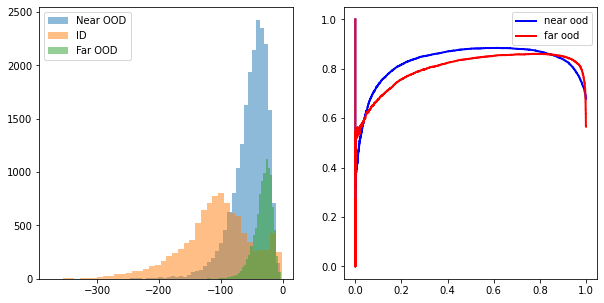

Near AUROC:0.8118027403846154, Far AUROC: 0.8981179699999999


In [24]:
auroc = plot(id_score,near_ood_score,far_ood_score,name='DDU',reverse=True)
print("Near AUROC:{}, Far AUROC: {}".format(auroc[0],auroc[1]))

## Calibration

In [13]:
val_score = []
val_y_true = []
with torch.no_grad():
    for image,label in val_id_loader:
        feature = model.net(image.to('cuda')).cpu()
        logit = model(image.to('cuda')).cpu()
        _, pred_logit = torch.max(logit,dim=-1)
        val_y_true += (pred_logit == label).cpu().numpy().tolist()
        q = gmm.q(feature)
        q = -q/scale
        val_score += q.numpy().tolist()
val_score = np.asarray(val_score)


ECE(%):  0.32172150708520963


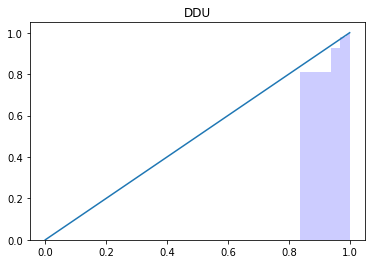

In [19]:
cval_score_en = val_score*-1
cid_score_en = id_score* -1
min_en= cval_score_en.min() -1 
max_en = cval_score_en.max() +1
cal = histogram_binning_calibrator(15,min_en, max_en)
cal.fit(cval_score_en,val_y_true)
prob_pred, prob_true, ece = cal.inference(cid_score_en, y_true)

plot_confidence_hist(prob_true,prob_pred,'DDU')